In [2]:
from numpy import *
from scipy import signal
from scipy.integrate import quad
import TMQGP as tm
import tqdm.notebook as tqdm
from QuarkTM import Particle, Channel
import QuarkTM
import pickle
import matplotlib

from syntax_sugar import pipe, END
from syntax_sugar import thread_syntax as t, process_syntax as p

import multiprocessing
NTHR = 14

import h5py

In [3]:
erange = linspace(-5, 5, 201)
qrange = linspace(0, 5, 51)

In [4]:
pQ = Particle(0.5, qrange, erange)

In [5]:
ch = Channel(pQ, pQ, 0.2, screen=0)

In [6]:
ch.populate_T()

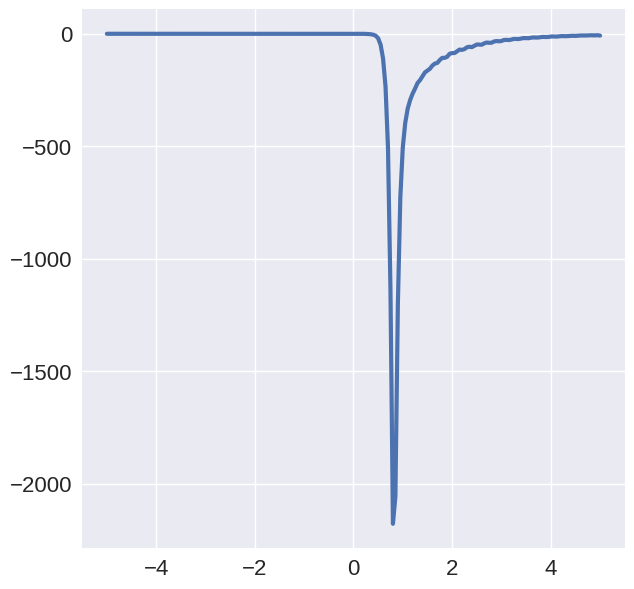

In [7]:
plt.plot(erange, imag(ch.TM[:, 0]))

Reference sigma

In [8]:
iEps = tm.Interpolator(qrange, pQ.om0(qrange), 'linear')

In [9]:
ress = []
for q in tqdm.tqdm(qrange):
    res = pipe(erange) | p[lambda z: tm.sigma_ff_onshell(z, q, ch.T, ch.iImT, ch.p_j.R, iEps, iEps)]*(NTHR//1) | END
    ress += [res]

  0%|          | 0/51 [00:00<?, ?it/s]

In [10]:
ress = array(ress).transpose()

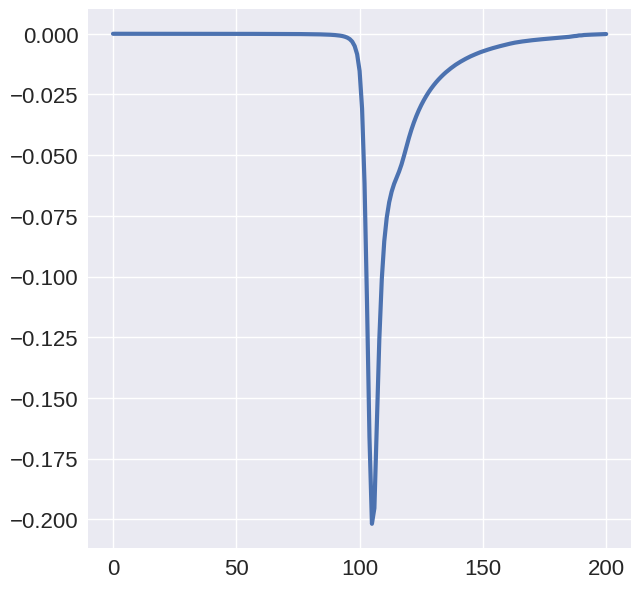

In [11]:
plt.plot(ress[:, 0])

Try flattened version

In [12]:
Ntot = len(erange)*len(qrange)

pairs = np.array([[[q, e] for e in erange] for q in qrange]).reshape(1, Ntot, 2)[0]

In [13]:
pairs

array([[ 0.  , -5.  ],
       [ 0.  , -4.95],
       [ 0.  , -4.9 ],
       ...,
       [ 5.  ,  4.9 ],
       [ 5.  ,  4.95],
       [ 5.  ,  5.  ]])

In [14]:
import multiprocess

In [137]:
with multiprocess.Pool(14) as pool:
    res_mp = pool.starmap(tm.sigma_ff_onshell, tqdm.tqdm([[z[1], z[0], ch.T, ch.iImT, pQ.R, iEps, iEps] for z in pairs]))

  0%|          | 0/10251 [00:00<?, ?it/s]

In [ ]:
with multiprocess.Pool(14) as pool:
    res_mp = list(tqdm.tqdm(pool.imap(lambda z: tm.sigma_ff_onshell(*z), [[z[1], z[0], ch.T, ch.iImT, pQ.R, iEps, iEps] for z in pairs]), 
                      total=len(qrange)*len(erange)))

In [113]:
res_mp = array(res_mp).reshape(len(qrange), len(erange)).transpose()

In [138]:
from tqdm.contrib.concurrent import process_map

In [140]:
def func(z):
    tm.sigma_ff_onshell(*z)

In [144]:
res_cc = process_map(func, [[z[1], z[0], ch.T, ch.iImT, pQ.R, iEps, iEps] for z in pairs], max_workers=32, chunksize=1)

  0%|          | 0/10251 [00:00<?, ?it/s]

In [15]:
ress_pairs = array(pipe(pairs) | p[lambda z: tm.sigma_ff_onshell(z[1], z[0], ch.T, ch.iImT, ch.p_j.R, iEps, iEps)]*(NTHR//1) | END)

In [16]:
ress_pairs.shape

(10251,)

In [21]:
ress_pairs = ress_pairs.reshape(len(qrange), len(erange)).transpose()

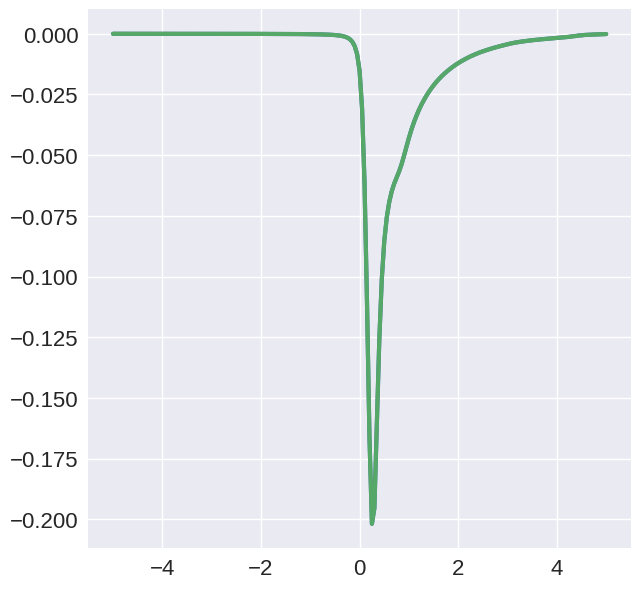

In [22]:
plt.plot(erange, ress[:, 0])
plt.plot(erange, ress_pairs[:, 0])